In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
S8_initial_M = 2.6730
S4_initial_M = 0.0128
S2_initial_M = 4.3321e-6
S1_initial_M = 1.6321e-6
Sp_initial_M = 2.7e-06

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

m_s_M = S8_initial_M + S4_initial_M + S2_initial_M + S1_initial_M + Sp_initial_M

S8_initial_frac_M  = S8_initial_M/m_s_M
S4_initial_frac_M  = S4_initial_M/m_s_M
S2_initial_frac_M  = S2_initial_M/m_s_M
S1_initial_frac_M  = S1_initial_M/m_s_M
Sp_initial_frac_M  = Sp_initial_M/m_s_M

S8_initial_hunt = S8_initial_frac_M*m_s_hunt
S4_initial_hunt = S4_initial_frac_M*m_s_hunt
S2_initial_hunt = S2_initial_frac_M*m_s_hunt
S1_initial_hunt = S1_initial_frac_M*m_s_hunt
Sp_initial_hunt = Sp_initial_frac_M*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        #S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [26]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016_3_current()
current = 2*0.0211
hours = 15
time_in_seconds = hours*3600
# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for Terminal Voltage [V]": 2.4,#discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        #"Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        #"Precipitation rate [s-1]": 5,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.15,
        "Standard Potential L [V]": 2.1,
        "Standard Potential H [V]": 2.38,
        #"Ambient Temperature [K]" : 302
        #"S saturation mass [g]": 1e-5,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_hunt_3_current = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_hunt_3_current.solve(np.linspace(0, time_in_seconds, 1000))

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_

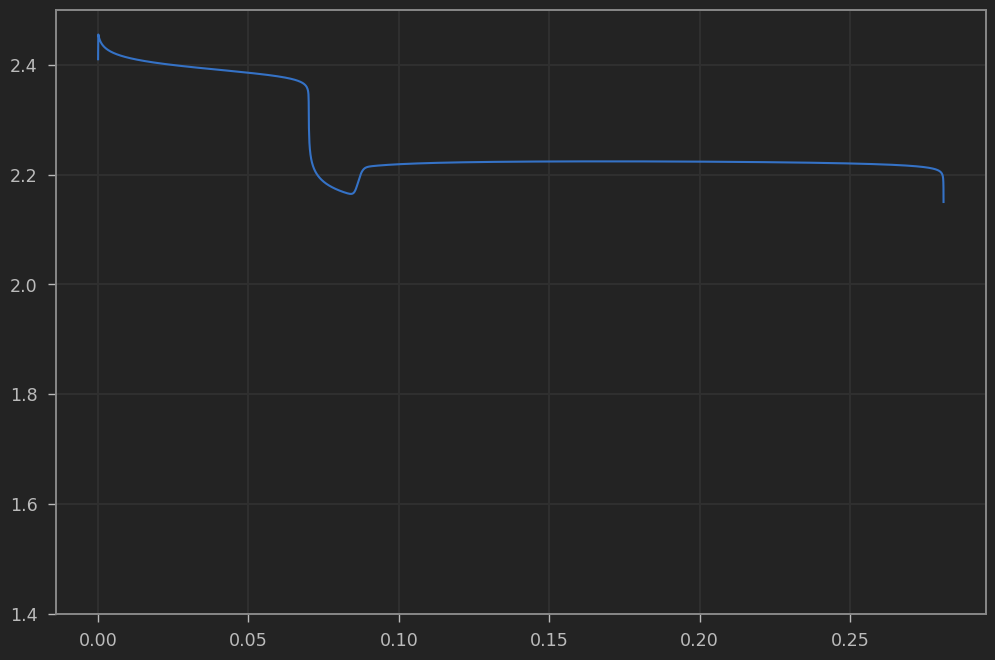

In [27]:
voltage = sim_hunt_3_current.solution['Terminal voltage [V]'].entries
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,voltage)
#plt.plot(voltage312)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

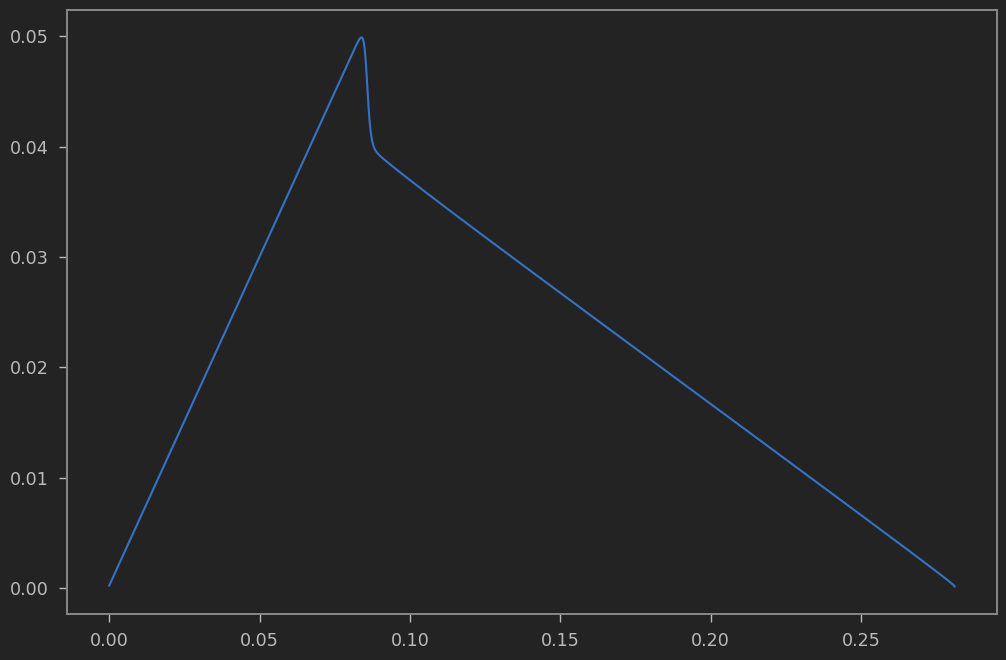

In [11]:
S4 = sim_hunt_3_current.solution['S4 [g]'].entries
S2 = sim_hunt_3_current.solution['S2 [g]'].entries
S1 = sim_hunt_3_current.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,Li)

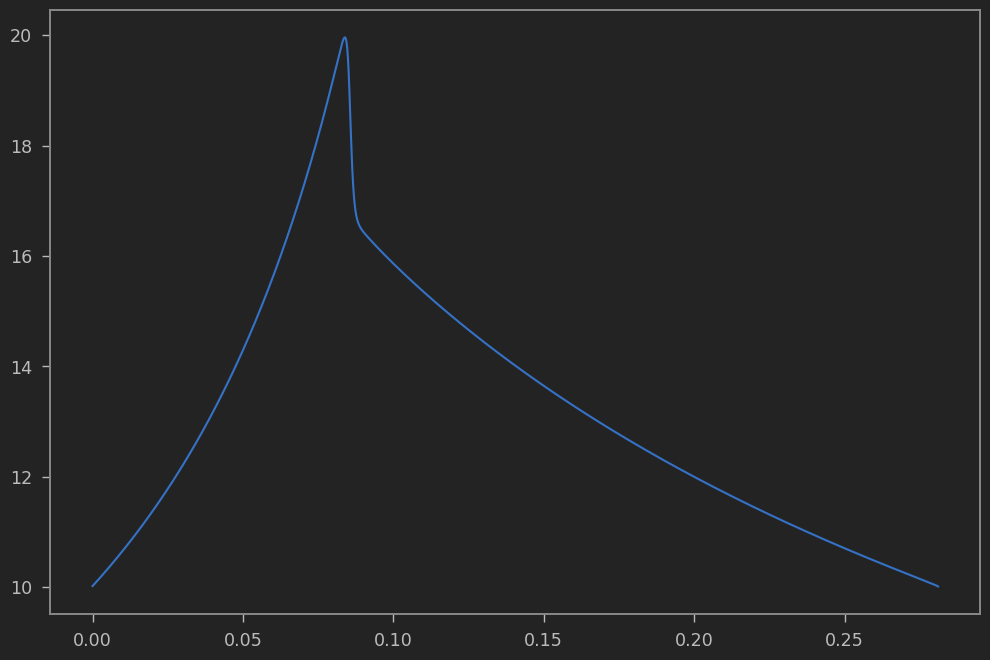

In [13]:
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,1/(0.1 - Li))